In [1]:
import numpy as np

# Load data from NPZ file
data = np.load('train_data.npz')

images = data['images']
features = data['features']
labels = data['labels']
classes = data['classes']

print(f"Images Shape: {images.shape}")
print(f"Features Shape: {features.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Classes: {classes}")

# Print number of unique values in each class
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(classes, counts):
    print(f"Class '{label}': {count} samples")

print("\nTotal samples:", len(labels))


Images Shape: (6600, 224, 224)
Features Shape: (6600, 8)
Labels Shape: (6600,)
Classes: ['gaussian' 'lognormal' 'poisson' 'rayleigh' 'saltpepper']
Class 'gaussian': 1200 samples
Class 'lognormal': 1500 samples
Class 'poisson': 1200 samples
Class 'rayleigh': 1500 samples
Class 'saltpepper': 1200 samples

Total samples: 6600


In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Parameters
input_shape = (224, 224, 1)  # Shape of the input images
num_classes = len(classes)  # Number of classes

# Convert labels to categorical
labels_categorical = to_categorical(labels, num_classes=num_classes)

# Split data into training and validation sets
X_train, X_test, features_train, features_test, y_train, y_test = train_test_split(
            images, features, labels_categorical, test_size=0.2, random_state=42
        )

In [3]:
#Define the CNN model
# CNN Input Branch
cnn_input = layers.Input(shape=input_shape, name='noise_component_input')
        
# CNN layers focused on noise pattern recognition
x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

cnn_features = layers.Dense(128, activation='relu')(x)

# Statistical Features Input Branch
stats_input = layers.Input(shape=(8,), name='statistical_features_input')
stats_features = layers.Dense(32, activation='relu')(stats_input)
stats_features = layers.BatchNormalization()(stats_features)

# Combine features
combined = layers.Concatenate()([cnn_features, stats_features])

# Final classification layers
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create model
model = models.Model(
    inputs=[cnn_input, stats_input],
    outputs=outputs
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_component_input (Inp  [(None, 224, 224, 1)]        0         []                            
 utLayer)                                                                                         
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         320       ['noise_component_input[0][0]'
                                                                    ]                             
                                                                                                  
 batch_normalization (Batch  (None, 222, 222, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [4]:
 # Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train model
history = model.fit(
    [X_train,features_train],
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/50
132/132 [==============================] - 146s 1s/step - loss: 1.0157 - accuracy: 0.5592 - val_loss: 2.2699 - val_accuracy: 0.2926 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 137s 1s/step - loss: 0.8046 - accuracy: 0.6366 - val_loss: 4.3326 - val_accuracy: 0.2320 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 128s 973ms/step - loss: 0.7467 - accuracy: 0.6603 - val_loss: 5.2554 - val_accuracy: 0.2348 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 128s 969ms/step - loss: 0.7122 - accuracy: 0.6716 - val_loss: 2.7720 - val_accuracy: 0.2689 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 123s 931ms/step - loss: 0.6739 - accuracy: 0.6795 - val_loss: 1.3274 - val_accuracy: 0.5341 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 126s 956ms/step - loss: 0.6780 - accuracy: 0.6839 - val_loss: 0.6347 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 7/50
132/132 [==============================] 

In [6]:
# Evaluate model
test_loss, test_accuracy = model.evaluate([X_test,features_test], y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

42/42 [==============================] - 8s 190ms/step - loss: 0.2205 - accuracy: 0.9121

Test accuracy: 0.9121


42/42 [==============================] - 8s 193ms/step


AttributeError: module 'matplotlib' has no attribute 'show'

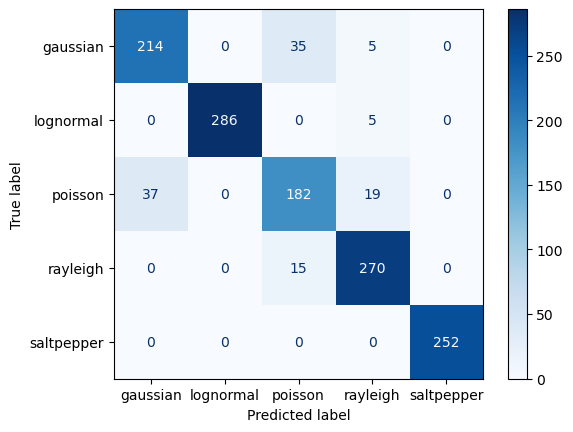

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as plt

y_val_pred = model.predict([X_test, features_test])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1), y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap=plt.cm.Blues)
plt.show()    

In [9]:
model.save('cnn_model.keras')